##  Packet classification for mobile applications
 

First, let's run the cell below to import all the packages that you will need during this project. 
- [numpy](http://www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [pandas](https://pandas.pydata.org) it offers data structures and operations for manipulating numerical tables and time series.
- [partial](https://www.learnpython.org/en/Partial_functions) allow one to derive a function with x parameters to a function with fewer parameters and fixed values set for the more limited function.
- [dtw](https://pypi.org/project/dtw/)  used as a similarity measured between temporal sequences.
- [Scikit](https://scikit-learn.org/stable/index.html) simple and efficient tools for predictive data analysis, Built on NumPy, SciPy, and matplotlib.


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random, tqdm, itertools

from dtw import dtw
from functools import partial
from multiprocessing import Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

 

### Methodology


The idea behind this is  that each observation or flow will create a cluster that belongs to it. For every iteration, the clusters are paired and  merged to the nearest cluster and move to the next. This operation of combination is governed by a distance metric between the flows of the pairs,(DTW, see Remark  III.1. IN REPORT) the operation ongoing until the entire number of clusters is iterated (220 clusters in my case).

First we have to cluster the dataste, you can skip this part since the dataset alread Built and stored in the folder

In [ ]:

# STAR BY ASSINGING INDEXES OF FLOWS TO THE CORRESPONDING APPLICATION
# AS PRESENTED IN THE DATASET.

apps_flows = dict(facebook=(2,9831),twitter=(50322,60745),gmail=(86581,96504),gplus=(96505,107296),
                       tumblr=(129976,140535),dropbox=(186678,196685),evernote=(235140,246623))

# THE ORIGINAL DATASET HAS 12 LABLES IN THE COLUMNS AS FOLLOW;
# [app,action,sequence,action_start,flow_number,IP_destination,IP_dest_resolved,port_source,port_destination,flow_length,flow_start,packets_length_total]
# WILL IMOPRT ONLY THE IMPORTANT COLUMNS
# CONVERT IT AND RETURN THE ACTUAL LISTS
def raw_data(path):
    df = pd.read_csv(path)
    data = df.loc[first_index:last_index,
                  ["action_start","packets_length_total","action","sequence"]].values
    return [string_list(row[1]) for row in data], data[:, [0, 2]]

# FUCNTION THAT TAKE STRING FROM THE DATASET  
# CONVERT IT AND RETURN THE ACTUAL LISTS
def string_list(s):
    return [int(sub.replace("[", "").replace("]", "")) for sub in s.split(",")]
# THE STARTING AND ENDING OF THE FLOWS IN THE INDEX
def range_indexes(start=2, end=1525):
    return [(i, j) for i in range(len_flows) for j in range(i+1, len_flows)]

# COMPUTE THE ABSOLUTE VALUES 
# AFTER SUBSTRACTING THE SECOND ELEMENT(y) FROM THE FIRST ELEMENT (x)
def absolute_value(x, y):
    return abs(x - y)

# BUILDING CDM CONCURRENTLY BY CONTROLING THE BEGININ AND THE ENDING OF THE INDEX
# AND EXCTRACT THE FLOWS FROM THE DATASET AND PASS THE DIST_FUNCTION INTO THE DTW
def build_cdm(flows, limits, dist_func): 
    begin = limits[0]
    finish = limits[1]
    return [dtw(flows[i], flows[j], dist_func)[0]
            for i in range(begin, finish)
            for j in range(i+1, len_flows)]

def cdm(flows, dist_func = absolute_value):
    return [dtw(flows[i], flows[j], dist_func)[0]
            for i in range(len_flows)
            for j in range(i+1, len_flows)]


# I USED THIS FUNCION TAKING ADVANTAGE OF SciPy TO IMPLEMENT THE HIERARCHICAL CLUSTERING "AGGLOMERATIVE"
# fcluster : ndarray An array of length n. T[i] is the flat cluster number to which original observation i belongs.
# maxclust: FINDS A MINIMUM THRESHOLD
def clustering(cdm, linkage_metric="average"):
    Z = linkage(cdm, method=linkage_metric)
    return fcluster(Z, selected_clusters, criterion='maxclust')


# SWAP BETWEEN ACTIONS BY SAVING THE CURRENT AND MOVE TO THE NEXT
def set_actions(clusters, data):
    actions = [], features = np.zeros(selected_clusters)
    cur_action_id = data[0][0], cur_action_label = data[0][1] # AVOID NONE VALUES
    for idx, row in enumerate(data):
        nxt_action_id = row[0], nxt_action_label = row[1]
        if cur_action_id != nxt_action_id:
            actions.append((cur_action_label, features))
            features = np.zeros(selected_clusters)
        features[clusters[idx] - 1] += 1
        cur_action_label = nxt_action_label
        cur_action_id = nxt_action_id
        if idx+1 == len_flows:
            actions.append((cur_action_label, features))
    return actions

# WRITING THE DATASET WHERE THE (C{}) IS THE COLUMNS HEADERS INCREASING BY 1 UP TO 220 IN THE FIRST ROW.
# THE DATA RAW ACTION LABEL IS ROW[0] AND THE LIST OF CLUSTERS IS ROW[1]
# CONVERT IT AND SAVE IT AS .CSV
def save_dataset(actions):
    with open("/Users/AB/mobile/datasets/{}.{}.csv".format(selected_dataset, selected_clusters), 'w') as f:
        headers = ""
        for i in range(selected_clusters):
            headers += "C{},".format(i + 1)
        headers += "action\n"
        f.write(headers)
        
        for row in actions:
            for c in row[1]:
                f.write("{},".format(int(c)))
            f.write("\"{}\"\n".format(row[0]))

# STARTING POINT
# UNCOMMENT ON THE DISERED APPLICATION TO BUILD AND SAVE THE DATASET

if __name__ == "__main__":
    selected_clusters = 220 
    PATH = "/Users/AB/mobile/datasets/apps_total_plus_filtered.csv"

    selected_dataset = "facebook"
    #selected_dataset = "twitter"
    #selected_dataset = "gmail"
    #selected_dataset = "gplus"
    #selected_dataset = "tumblr"
    #selected_dataset = "dropbox"
    #selected_dataset = "evernote"

# "NameError: name 'selected_dataset' is not defined"
# IF YOU RECIEVED THE ABOVE ERROR AT THE RUNNING TIME
# SIMPLY UNCOMMENT ON ONE OF THE SELECTED_DATASET

    first_index = apps_flows[selected_dataset][0]
    last_index = apps_flows[selected_dataset][1]    
    load_flows, feature_flows= raw_data(path=PATH) 
    len_flows = len(load_flows)
    run_code = True

    
# WITH POOL AS 5, CALL FUNCTION CDM ABOVE AND PROCESS THE STANDARD OUTPUT OF CDM
with Pool(5) as p:
    if run_code:
        # BUILDING THE CDM
        print("BUILDING CDM")
        print("THIS MAY TAKE A WHILE...")

        X_indexes = range_indexes()
        caller = partial(build_cdm, load_flows, absolute_value)
        
        # https://docs.python.org/3/library/itertools.html
        cdm_list = p.map(caller, X_indexes)
        cdm_list = list(itertools.chain(*cdm_list))
    else:
        cdm_list = cdm(flows=load_flows, dist_func=absolute_value)
    print("CDM BUILT SUCCESSFULLY")

    # BUILDING THE CLUSTERS, PREPARING AND SAVING THE DATASET
    C = clustering(cdm=cdm_list, linkage_metric="average")
    print("CLUSTERING BUILT SUCCESSFULLY")
    dataset = set_actions(clusters=C, data=feature_flows)
    save_dataset(dataset)
    print("BUILD SUCCESS")
    


### Methodology
The classification part utilizes supervised learning within its procedures. After the clustering of the applications in the dataset, and gaining a specific dataset belonging to a specific application, the supervised learning will take place in order to train/test the dataset taking advantage of Random Forest algorithm.

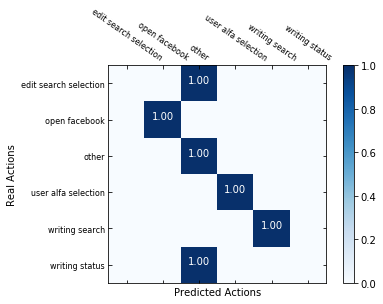

    facebook
***************
Precision: 0.91
***************
Recall:    0.96
***************
F-measure: 0.93
***************


In [3]:
actions = {    
"facebook":["open facebook","edit search selection","writing search","user alfa selection","writing status"],
"twitter":["open Twitter","contact selection","refresh home","discover selection","send selection","tweets selection","send tweet selection",],
"gmail":["open gmail","new mail","chats selection","sent selection"],
"gplus":["open gplus","refresh","user page","new selection", "post selection","plus post"],
"tumblr":["open tublr", "refresh home", "search page","home page","user likes","lighting"],
"dropbox":["open dropbox","favorites","new folder","file text input"],
"evernote":["open evernote","back to menu","market selection","edit note","done audio note","close evernote","done text note"] 
}

def other_actions(string, application):
    return "other" if string not in actions[application] else string


# NORMALIE THE APPLICATION AND PLOT 
# https://chrisalbon.com/python/basics
def plot_matrix(cm,classes,normalize=False,title="",cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.yticks(tick_marks, classes, fontsize=8)
    plt.xticks(tick_marks, classes, fontsize=8)
    plt.tick_params(axis="y",direction="in",right=True)
    plt.tick_params(axis="x",direction="in",labelbottom = False,labeltop=True, top=True,rotation=-35)

# PLOT CONFUSION MATRIX WITH FORMAT STRING 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "none")
    plt.xlabel('Predicted Actions')
    plt.ylabel('Real Actions')
    
# STARTING POINT
if __name__ == "__main__":
    
    selected_dataset = "facebook"
    #selected_dataset = "twitter"
    #selected_dataset = "gmail"
    #selected_dataset = "gplus"
    #selected_dataset = "tumblr"
    #selected_dataset = "dropbox"
    #selected_dataset = "evernote"
    
# "NameError: name 'selected_dataset' is not defined"
# IF YOU RECIEVED THE ABOVE ERROR AT THE RUNNING TIME
# SIMPLY UNCOMMENT ON ONE OF THE SELECTED_DATASET
    dataset = pd.read_csv("/Users/AB/mobile/datasets/{}.220.csv".format(selected_dataset))
    n_clusters = len(dataset.columns) - 1
    data = dataset.loc[:, "C1":"C{}".format(n_clusters)].values
    target = [other_actions(string, selected_dataset) for string in dataset.loc[:, "action"].values]

# https://www.datacamp.com/community/tutorials/random-forests-classifier-python
# SPLITS MATRICES INTO RANDOM TRAIN & TEST SUBSETS TAKING ADVANTAGE OF RANDOM FOREST
    x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
# COMPUTE CONFUSION MATRIX, PLOT AND SAVE THE APPLICATION AS A PDF
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=4)
    plt.figure()
    plot_matrix(cnf_matrix, classes=np.unique(target), normalize=True)                   
    plt.savefig("/Users/AB/mobile/plots/{}.pdf".format(selected_dataset), bbox_inches='tight')
    plt.show()
    
# COMPUTE AND PRINT PRECISION, REACLL AND F-MEASURE
    Precision, Recall, F_measure, _ = precision_recall_fscore_support(y_test,y_pred,average="weighted",warn_for=())
    print("    {}".format(selected_dataset))
    print("***************");
    print("Precision: {:.2f}".format(Precision))
    print("***************");
    print("Recall:    {:.2f}".format(Recall))
    print("***************");
    print("F-measure: {:.2f}".format(F_measure))
    print("***************");